In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
BASE = '/content/gdrive/My Drive/nlp-data/'

In [0]:
from fastai.text import *
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [0]:
def join_text(row):
    title, abstract = row.title, row.abstract
    return title + '\n' + abstract

In [0]:
df = pd.read_csv(BASE + 'labeled.tsv', sep='\t')
df['text'] = df.apply(join_text, axis=1)
df = df[['label', 'text']]

In [18]:
df_trn, df_val = train_test_split(df, stratify=df['label'], test_size=0.2)

df_trn.shape, df_val.shape

((407, 2), (102, 2))

In [0]:
data_lm = load_data(BASE, 'data_lm_export_5000a.pkl')

In [12]:
ls /content/gdrive/My\ Drive/nlp-data

data_lm_export_50000.pkl  ft_enc_50000.pth  labeled.tsv
data_lm_export_5000a.pkl  ft_enc_5000a.pth  unlabeled.tsv
data_lm_export_5000.pkl   ft_enc_5000.pth


In [14]:
# Classifier model data
data_class = TextClasDataBunch.from_df(train_df=df_trn, valid_df=df_val, path="", vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
data_lm.save(BASE+'data_lm_export.pkl')
data_class.save(BASE+'data_class_export.pkl')

data_lm = load_data(BASE, 'data_lm_export.pkl')
data_class = load_data(BASE, 'data_class_export.pkl', bs=64)

In [23]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(BASE+'ft_enc_5000a')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (407 items)
x: TextList
xxbos xxmaj an xxmaj algebraic xxmaj perspective on xxmaj multivariate xxmaj tight xxmaj wavelet xxmaj frames . xxup ii 
  xxmaj continuing our recent work we study polynomial masks of multivariate tight wavelet frames from two additional and complementary points of view : convexity and system theory . xxmaj we consider such polynomial masks that are derived by means of the unitary extension principle from a single polynomial . xxmaj we show that the set of such polynomials is convex and reveal its extremal points as polynomials that satisfy the quadrature mirror filter condition . xxmaj multiplicative structure of such polynomial sets allows us to improve the known upper bounds on the number of frame generators derived from box splines . xxmaj in the univariate and bivariate settings , the polynomial masks of a tight wavelet frame can be interpreted as the transfer function of a conservative multivariate line

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 5.25E-02


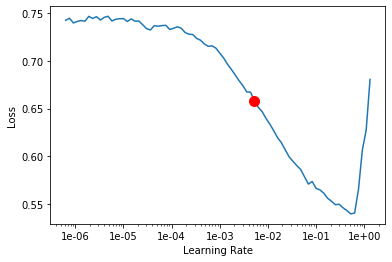

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [32]:
%%time 
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(BASE+'ft_enc_5000a')

learn.fit_one_cycle(3, min_grad_lr)

learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(5e-3, 2e-3), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.697154,0.665904,0.666667,00:02
1,0.632587,0.649479,0.676471,00:02
2,0.572068,0.616191,0.686275,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.478321,0.587278,0.686275,00:02
1,0.437571,0.577711,0.656863,00:02
2,0.394178,0.571419,0.656863,00:03


CPU times: user 9.64 s, sys: 6.33 s, total: 16 s
Wall time: 17 s


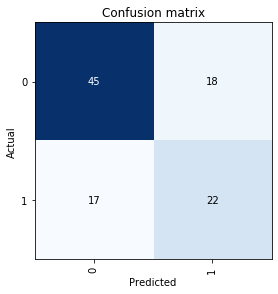

In [33]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
learn.export(BASE+'class-export')

In [36]:
learn.show_results()

text,target,prediction
"xxbos xxmaj beyond xxmaj bilinear : xxmaj generalized xxmaj multimodal xxmaj factorized xxmaj high - order xxmaj pooling for xxmaj visual xxmaj question xxmaj answering \n xxmaj visual question answering ( xxup vqa ) is challenging because it requires a simultaneous understanding of both visual content of images and textual content of questions . xxmaj to support the xxup vqa task , we need to find good solutions for",0,0
"xxbos xxmaj approximating the xxmaj largest xxmaj eigenvalue of the xxmaj modified xxmaj adjacency xxmaj matrix of xxmaj networks with xxmaj heterogeneous xxmaj node xxmaj biases \n xxmaj motivated by its relevance to various types of dynamical behavior of network systems , the maximum eigenvalue $ \ xxunk of the adjacency matrix $ xxup a$ of a network has been considered , and mean - field - type approximations",0,0
"xxbos xxmaj supervised - xxmaj learning for xxmaj multi - xxmaj hop xxup mu - xxup mimo xxmaj communications with xxmaj one - xxmaj bit xxmaj transceivers \n xxmaj this paper considers a nonlinear multi - hop multi - user multiple - input multiple - output ( xxup mu - xxup mimo ) relay channel , in which multiple users send information symbols to a multi - antenna base",0,0
"xxbos xxmaj exploring uncertainties in dark energy constraints using current observational data with xxmaj planck 2015 distance priors \n xxmaj we present the distance priors that we have derived from the 2015 xxmaj planck data , and use these in combination with the latest observational data from xxmaj type xxmaj ia xxmaj supernovae ( sne xxmaj ia ) and galaxy clustering , to explore the systematic uncertainties in dark",0,0
xxbos xxmaj numerical predictions of surface effects during the xxunk close approach of asteroid xxunk xxmaj xxunk \n xxmaj asteroid ( xxunk ) xxmaj xxunk ' close approach in xxunk will be one of the most significant small - body encounter events in the near future and offers a good opportunity for in situ exploration to determine the asteroid 's surface properties and measure any tidal effects that might,1,0
